In [1]:
%pylab inline
import scipy
import itertools
import numpy as np
import matplotlib.pyplot as plt

from pyiga import bspline, assemble, vform, geometry, vis, solvers, quadrature, topology
from patchmesh import *

Populating the interactive namespace from numpy and matplotlib


In [21]:
from pyiga import bspline, vis, assemble
import copy

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
#import BSegments

def bdspec_to_int(bdspec):
    return 2 * bdspec[0][0] + bdspec[0][1]    # convert to a boundary index (0..5)
    
def corners(geo, ravel=False):
    """Return an array containing the locations of the 2^d corners of the given
    geometry."""
    vtx = geo.grid_eval(geo.support)
    if ravel:
        return vtx.reshape((-1, geo.dim))
    return vtx

def edges(corners):
    C=np.array(corners).reshape(2,2,2)
    return np.vstack((C.transpose((0,1,2)).reshape(-1,2), C.transpose((0,2,1)).reshape(-1,2), C.transpose((1,2,0)).reshape(-1,2)))

# Data structures:
#
# - vertices is a list of topological vertices, the entries are their locations
#
# - patches is a list of tuples:
#       ((kvs, geo), boundaries)
#   - kvs are the tensor product knot vectors
#   - geo is the geometry map
#   - boundaries is a list of the six boundaries of the patch; each boundary
#     is a BSegments object describing the boundary segments on that boundary as a binary search tree. 
#     The leafes are the segments and the respective parents designate the axis where it splits the segments before. 
#     Each boundary has at least 1 leaf (a single
#     segment).
#
# - interfaces is a dict which stores connectivity information between boundary
#   segments on neighboring patches: an entry of the form
#     interfaces[(p0, b0, s0)] == ((p1, b1, s1), flip)
#   means that segment s0 of boundary b0 of patch p0 (all integer indices) is
#   connected to segment s1 of boundary b1 of patch p1. flip is a
#   (d-1)-dimensional tuple indicating whether each coordinate axis runs in
#   opposite direction in the two patches. This information is symmetrical, so
#   each entry like the above has a corresponding second entry with the roles
#   of (p0,b0,s0) and (p1,b1,s1) reversed.
#

class PatchMesh3D:
    def __init__(self, patches = None):
        self.vertices = []
        self.edges=[]
        self.patches = []
        self.interfaces = dict()
        
        self.Nodes = {'T0':dict(), 'T1':dict(), 'T2':dict()}
        self.Edges = {'T0':dict(), 'T1':dict()}
        #self.T_nodes = dict()

        if patches:
            # add interfaces between patches
            conn, interfaces = assemble.detect_interfaces(patches)
            assert conn, 'patch graph is not connected!'
            
            for p,patch in enumerate(patches):
                kvs, geo = patch
                # add/get vertices (checks for duplicates)
                vtx = [self.add_vertex(c)[0] for c in corners(geo, ravel=True)]
                edg = [self.add_edge(vtx1, vtx2) for vtx1, vtx2 in edges(vtx)]
                #edges = [(self.add_vertex(vtx1), self.add_vertex(vtx2)) for (vtx1, vtx2) in edges(geo)]
                #edges = [self.add_edge(e) for e in edges]
                
                # add boundaries in fixed order
                self.add_patch(patch, (
                    BSegments([(vtx[0], vtx[1]), (vtx[2], vtx[3]), (vtx[0], vtx[2]), (vtx[1], vtx[3])], 0),    #front
                    BSegments([(vtx[4], vtx[5]), (vtx[6], vtx[7]), (vtx[4], vtx[6]), (vtx[5], vtx[7])], 0),    #back
                    BSegments([(vtx[0], vtx[1]), (vtx[4], vtx[5]), (vtx[0], vtx[4]), (vtx[1], vtx[5])], 1),    #bottom
                    BSegments([(vtx[2], vtx[3]), (vtx[6], vtx[7]), (vtx[2], vtx[6]), (vtx[3], vtx[7])], 1),    #top
                    BSegments([(vtx[0], vtx[2]), (vtx[4], vtx[6]), (vtx[0], vtx[4]), (vtx[2], vtx[6])], 2),    #left
                    BSegments([(vtx[1], vtx[3]), (vtx[5], vtx[7]), (vtx[1], vtx[5]), (vtx[3], vtx[7])], 2),    #right
                ))
                    
                for c_spec, v in zip(topology.face_indices(3,0), vtx):
                    if v in self.Nodes['T0']:
                        self.Nodes['T0'][v][p] = c_spec
                    else:
                        self.Nodes['T0'][v]={p : c_spec}
                        
                for e_spec, e in zip(topology.face_indices(3,1), edg):
                    if e in self.Edges['T0']:
                        self.Edges['T0'][e][p] = e_spec
                    else:
                        self.Edges['T0'][e]={p: e_spec}

            for (p0, bd0, p1, bd1, conn_info) in interfaces:
                self.add_interface(p0, bdspec_to_int(bd0), tuple(), p1, bdspec_to_int(bd1), tuple(), conn_info)

            #self.sanity_check()

    @property
    def numpatches(self):
        return len(self.patches)
            
    def add_vertex(self, pos):
        """Add a new vertex at `pos` at return new index and `False` or return its index and `True` if one already exists there."""
        if self.vertices:
            distances = [np.linalg.norm(vtxpos - pos) for vtxpos in self.vertices]
            i_min = np.argmin(distances)
            if distances[i_min] < 1e-14:
                return i_min, False
        self.vertices.append(pos)
        return len(self.vertices) - 1, True
    
    def add_edge(self, vtx1, vtx2): 
        """Add a new edge from vtx1 to vtx2 or return its index if one already exists there."""
        if (vtx1, vtx2) in self.edges:
            return self.edges.index((vtx1, vtx2))
        elif (vtx2, vtx1) in self.edges:
            return self.edges.index((vtx2, vtx1))
        else:
            self.edges.append((vtx1, vtx2))
            return len(self.edges) - 1
    
    def remove_edge(self,vtx1,vtx2):
        if (vtx1, vtx2) in self.edges:
            self.edges.remove((vtx1, vtx2))
        elif (vtx2, vtx1) in self.edges:
            self.edges.remove((vtx2, vtx1))
        else:
            return

    def get_vertex_index(self, pos):
        if self.vertices:
            distances = [np.linalg.norm(vtxpos - pos) for vtxpos in self.vertices]
            i_min = np.argmin(distances)
            if distances[i_min] < 1e-14:
                return i_min
        raise ValueError('no vertex found at %s' % (pos,))

    def add_patch(self, patch, boundaries):
        self.patches.append((patch, boundaries))

    def add_interface(self, p0, b0, s0, p1, b1, s1, flip):
        """Join segment s0 of boundary b0 of patch p0 with segment s1
        of boundary b1 of p1.
        """
        #bds0 = self.boundaries(p0)
        #bds1 = self.boundaries(p1)
        #assert b0 < len(bds0) and b1 < len(bds1)
        #assert s0 < len(bds0[b0]) and s1 < len(bds1[b1])
        S0 = (p0, b0, s0)
        S1 = (p1, b1, s1)
        self.interfaces[S0] = (S1, flip)
        self.interfaces[S1] = (S0, flip)
        
    def refine(self, patches = None, mult=1):
        if isinstance(patches, dict):
            assert max(patches.keys())<self.numpatches and min(patches.keys())>=0, "patch index out of bounds."
            patches = patches.keys()
        elif isinstance(patches, (list, set, np.ndarray)):
            assert max(patches)<self.numpatches and min(patches)>=0, "patch index out of bounds."
        elif patches==None:
            patches = np.arange(self.numpatches)
        elif np.isscalar(patches):
            patches=(patches,)
        else:
            assert 0, "unknown input type"
            
        for p in patches:
            (kvs,geo), b = self.patches[p]
            new_kvs = tuple([kv.refine(mult=mult) for kv in kvs])
            self.patches[p]=((new_kvs, geo), b)

    def _reindex_interfaces(self, p, b, old_s, ofs = tuple(), r = 0, new_p=None):
        old_s = list(old_s)
        if r > 0:
            new_s = [ofs + s[:-r] for s in old_s]
        else:
            new_s = [ofs + s for s in old_s]
        if new_p is None:
            new_p = p
        S_old = [(p, b, s) for s in old_s]
        S_new = [(new_p, b, s) for s in new_s]
        old_intf = [self.interfaces.pop(S, None) for S in S_old]
        for Sn, intf in zip(S_new, old_intf):
            if intf:
                self.interfaces[Sn] = intf
                self.interfaces[intf[0]] = (Sn, intf[1])

    def split_boundary_segment(self, p, b, axis, s, new_edge):
        """Split the boundary segment `s` on boundary `b` of patch `p` by
        inserting the new vertex with index `new_vtx`.

        If the segment interfaces with another patch, also splits the
        corresponding segment on the other side and updates the interface
        information.
        """
        bd = self.boundaries(p)[b] 
        #assert 0 <= s < len(bd) - 1
        bd.split_segment(ax=axis, seg=s, edge=new_edge)
        # shift all later interfaces up by one
        #self._reindex_interfaces(p, b, range(s + 1, len(bd) - 2), 1)

        # also split the matching boundary segment on neighboring patch, if any
        other = self.get_matching_interface(p, b, s)
        if other:
            (p1, b1, s1) = other
            bd1 = self.boundaries(p1)[b1]
            #bd1.insert(s1 + 1, new_vtx)
            
            ### need to check axis and possibly change it here if boundarys have different normal axis (if a the neighbouring patch was rotated e.g.)
            bd1.split_segment(ax=axis, seg=s1, edge=new_edge) 
            
            # shift all later interfaces up by one
            #self._reindex_interfaces(p1, b1, range(s1 + 1, len(bd1) - 2), +1)

            # fix the new interfaces to point to each other
            flip = self.interfaces[(p, b, s)][1]
            
            self.interfaces.pop((p, b, s))
            self.interfaces.pop((p1, b1, s1))
            
            bd_axis = axis - 1*(axis > self.boundaries(p)[b].normal_axis)
            if flip[bd_axis]:
                # indices are running in opposite directions on the two sides
                self.interfaces[(p, b, s + (0,))] = ((p1, b1, s1 + (1,)), flip)
                self.interfaces[(p1, b1, s1 + (1,))] = ((p, b, s + (0,)), flip)

                self.interfaces[(p, b, s + (1,))] = ((p1, b1, s1 + (0,)), flip)
                self.interfaces[(p1, b1, s1 + (0,))] = ((p, b, s + (1,)), flip)
            else:
                self.interfaces[(p, b, s + (0,))] = ((p1, b1, s1 + (0,)), flip)
                self.interfaces[(p1, b1, s1 + (0,))] = ((p, b, s + (0,)), flip)

                self.interfaces[(p, b, s + (1,))] = ((p1, b1, s1 + (1,)), flip)
                self.interfaces[(p1, b1, s1 + (1,))] = ((p, b, s + (1,)), flip)

    def split_patch_boundary(self, p, b, xi, axis, new_edge, new_p):
        """Split the boundary `b` of patch `p` at a vertex which lies at
        parameter value `xi` of the boundary curve and has coordinates
        `vtxpos`.

        Returns the index of the first segment after the new vertex.

        It is valid to pass a vertex which is already contained in the
        boundary, in which case nothing is inserted and the correct index is
        returned.
        """

        #vtx1, vtx2 = self.boundaries(p)[b][::len(self.boundaries(p)[b])-1]
        #new_edge = self.edges[new_edge]
        try:
            # is the new edge already contained in the boundary?
            if self.boundaries(p)[b].axis != axis:
                raise ValueError
        except ValueError:
            # otherwise, we need to insert it, split the segment and insert a new T_node (or corner at the boundary of the domain)
            seg = self._find_boundary_split_index(p, b, xi, new_edge)
            self.split_boundary_segment(p, b, axis, seg, new_edge)
            self.add_edge(*new_edge) ###T_edge
        else:
            return 

    def _find_boundary_split_index(self, p, bdidx, xi_split, vtx_idx):
        (kvs, geo), boundaries = self.patches[p]
        segments = boundaries[bdidx]
        # simple case: if a single interval covers the boundary, we split it
        if segments.is_leaf():
            return tuple()
        #bd_geo = geo.boundary((bdidx // 2, bdidx % 2))
        #bd_vtx_xi = [bd_geo.find_inverse(self.vertices[j])[0] for j in segments]
        # find segment where xi_split would need to be inserted to maintain order
        #return np.searchsorted(bd_vtx_xi, xi_split) - 1

    def split_patch(self, p, axis = None, mult=1):
        if axis == None:
            (p1, p2), new_kvs0 = self.split_patch(p,  axis=2, mult=mult)
            (p1, p3), new_kvs1 = self.split_patch(p1, axis=1, mult=mult)
            (p2, p4), _        = self.split_patch(p2, axis=1, mult=mult)
            (p1, p5), new_kvs2 = self.split_patch(p1, axis=0, mult=mult)
            (p2, p6), _        = self.split_patch(p2, axis=0, mult=mult)
            (p3, p7), _        = self.split_patch(p3, axis=0, mult=mult)
            (p4, p8), _        = self.split_patch(p4, axis=0, mult=mult)
                
            new_kvs = (new_kvs2[0], new_kvs1[1], new_kvs0[2])
            return (p1, p2, p3, p4, p5, p6, p7, p8), new_kvs
            #self.split_patch(p1_, 1, mult=mult)
        
        (kvs, geo), boundaries = self.patches[p]
        kv = kvs[axis].refine(mult=mult)
        
        #split_xi = sum(kv.support())/2.0
        #split_idx = kv.findspan(split_xi)+1
     
        m_idx = len(kv.mesh)//2
        mesh_ofs = kv.mesh_span_indices()
        split_idx = mesh_ofs[m_idx]
        split_mult = mesh_ofs[m_idx]-mesh_ofs[m_idx-1]
        split_xi = kv.kv[split_idx]    # parameter value where we split the KV
        new_knots1 = np.concatenate((kv.kv[:split_idx], (kv.p+1-(mult-1)) * (split_xi,)))
        new_knots2 = np.concatenate(((kv.p) * (split_xi,), kv.kv[split_idx:]))
        new_kvs = tuple([bspline.KnotVector(np.concatenate((kv.kv[:split_idx], (kv.p-1) * (split_xi,), kv.kv[split_idx:])),kv.p) if d==axis else kvs[d] for d in range(3)])
            
        # create new kvs and geo for first patch
        kvs1 = list(kvs)
        kvs1[axis] = bspline.KnotVector(new_knots1, kv.p)
        geo1 = copy.copy(geo)
        geo1.support = tuple(kv.support() for kv in kvs1)
        kvs1 = tuple(kvs1)
        
        # create new kvs and geo for second patch
        kvs2 = list(kvs)
        kvs2[axis] = bspline.KnotVector(new_knots2, kv.p) 
        geo2 = copy.copy(geo)
        geo2.support = tuple(kv.support() for kv in kvs2)
        kvs2 = tuple(kvs2)

        # dimension-independent description of front/bottom/left and back/top/right edge
        lower, upper = 2 * axis, 2 * axis + 1

        # copy existing boundaries, they will be corrected below
        boundaries = list(boundaries)
        new_boundaries = [bd for bd in boundaries]

        new_p =  self.numpatches
        new_vertices = []
        
        if axis == 0:                           # z-axis
            split_boundaries = [2, 3, 4, 5]     # bottom, top, left and right were split
            splitC = corners(geo1)[1,:,:,:].reshape(-1,3)
            C = [self.add_vertex(c)[0] for c in corners(geo).transpose((0,1,2,3)).reshape(-1,3)]
        elif axis == 1:                         # y-axis
            split_boundaries = [0, 1, 4, 5]     # front, back, left and right were split
            splitC = corners(geo1)[:,1,:,:].reshape(-1,3)
            C = [self.add_vertex(c)[0] for c in corners(geo).transpose((1,0,2,3)).reshape(-1,3)]
        elif axis == 2:                         # x-axis
            split_boundaries = [0, 1, 2, 3]     # front, back, bottom and top were split
            splitC = corners(geo1)[:,:,1,:].reshape(-1,3)
            C = [self.add_vertex(c)[0] for c in corners(geo).transpose((2,0,1,3)).reshape(-1,3)]
        else:
            assert False, 'This axis does not exist.'
            
        for i, c in enumerate(splitC):
            vtx, is_new = self.add_vertex(c)
            new_vertices.append(vtx)
            if is_new:
                self.remove_edge(C[i], C[i+4])
                self.add_edge(C[i], vtx)
                self.add_edge(vtx, C[i+4])

        #new_edges = [(new_vertices[0], new_vertices[1]), (new_vertices[2], new_vertices[3]), (new_vertices[0], new_vertices[2]), (new_vertices[1], new_vertices[3])]
        new_edges = [self.add_edge(new_vertices[i1], new_vertices[i2]) for i1, i2 in zip([0,2,0,1],[1,3,2,3])]
        # move existing interfaces from upper side of old to upper of new patch 
        self._reindex_interfaces(p, upper, boundaries[upper].return_segments(), new_p=new_p)

        boundaries[upper]     =  BSegments([self.edges[e] for e in new_edges], axis)   # upper edge of new lower patch
        new_boundaries[lower] =  BSegments([self.edges[e] for e in new_edges], axis)   # lower edge of new upper patch

        # add interface between the two new patches
        self.add_interface(p, upper, tuple(), new_p, lower, tuple(), (False, False))

        for sb, new_edge in zip(split_boundaries, new_edges):
            #print(self.boundaries(p)[sb].normal_axis)
            #bd_axis = axis - 1*(axis > self.boundaries(p)[sb].normal_axis)
            #print(self.edges[new_edge])
            self.split_patch_boundary(p, sb, split_xi, axis, self.edges[new_edge], new_p)
            
            # split the boundaries of the new patches at this edge
            new_bd = self.boundaries(p)[sb]
            boundaries[sb] = new_bd.lower
            new_boundaries[sb] = new_bd.upper

            # change patch index for all interfaces from the split part of the boundary
            self._reindex_interfaces(p, sb, [(1,) + s for s in new_boundaries[sb].return_segments()], ofs=tuple(), r = 1, new_p=new_p)
            self._reindex_interfaces(p, sb, [(0,) + s for s in new_boundaries[sb].return_segments()], ofs=tuple(), r = 1)
            
        # change patch index for all corner nodes and T nodes on the upper edge of old patch   
        
        #also change patch index of possible T_nodes at the new boundaries in the different axis direction (left and right)
            
        self.patches[p] = ((kvs1, geo1), tuple(boundaries))
        self.patches.append(((kvs2, geo2), tuple(new_boundaries)))
        
        return (p, new_p), new_kvs     # return the two indices of the split patches and the joined knot mesh over the 2 patches
    
            
    def split_patches(self, patches=None, mult=1, dir_data = None):
        
        if isinstance(patches, dict):
            assert max(patches.keys())<self.numpatches and min(patches.keys())>=0, "patch index out of bounds."
        elif isinstance(patches,int):
            assert patches >=0 and patches < 3, "dimension error."
            patches = {p:patches for p in range(self.numpatches)}
        elif isinstance(patches, (list, set, np.ndarray)):
            assert max(patches)<self.numpatches and min(patches)>=0, "patch index out of bounds."
            patches = {p:None for p in patches}
        elif patches==None:
            patches = {p:None for p in range(self.numpatches)}
        else:
            assert 0, "unknown input type"

        new_patches = dict()
        new_kvs = dict()
        for p in patches.keys():
            if dir_data==None:
                new_p, new_kvs_ = self.split_patch(p,axis=patches[p], mult=mult)
            else:
                split_dirichlet_data(p, self.numpatches, dir_data, axis=patches[p])
                new_p, new_kvs_= self.split_patch(p, axis=patches[p], mult=mult)
            new_patches[p] = new_p
            new_kvs[p] = new_kvs_
            
        return new_patches, new_kvs

    def boundaries(self, p):
        """Get the boundaries for patch `p`.

        A 2D patch has four boundaries, and each one is a list of vertex
        indices describing individual segments of the boundary.
        
        A 3D patch has six boundaries, and each one is a list of 4 tuples 
        of vertex indices each describing the edges enclosing the boundary. 
        """
        return self.patches[p][1]

    def get_matching_interface(self, p, boundary, segment):
        """Get the boundary/interface which is connected to the given boundary/interface."""
        assert 0 <= p < len(self.patches)
        bdrs = self.boundaries(p)
        assert 0 <= boundary < len(bdrs)
        #assert 0 <= segment < len(bdrs[boundary]) - 1
        matching = self.interfaces.get((p, boundary, segment))
        if matching:
            return matching[0]
        else:
            return None     # no matching segment - must be on the boundary
        
    def draw(self, knots = True, vertex_idx = False, edge_idx=False, patch_idx = False, nodes=False, figsize=(8,8)):
        """draws a visualization of the patchmesh in 2D."""
        fig=plt.figure(figsize=figsize)
        ax = plt.axes(projection='3d')
        ax.grid(False)
        
        for ((kvs, geo),_) in self.patches:
            if knots:
                vis.plot_geo(geo, gridx=kvs[0].mesh, gridy=kvs[1].mesh, gridz=kvs[2].mesh, color='lightgray')       
            vis.plot_geo(geo, grid=2)
           
        if nodes:
            ax.scatter(*np.transpose([vtx[[0,1,2]] for vtx in self.vertices]), color='red')
            #ax.scatter(*np.transpose([vtx[[0,1,2]] for vtx in self.vertices]), color='red')

        if patch_idx:
            for p in range(len(self.patches)):        # annotate patch indices
                geo = self.patches[p][0][1]
                center_xi = np.flipud(np.mean(geo.support, axis=1))
                center = geo(*center_xi)
                ax.text(*(center[[0,1,2]]), str(p), fontsize=18, color='green')
            
        if vertex_idx:
            for i, vtx in enumerate(self.vertices):   # annotate vertex indices
                ax.text(*(vtx[[0,1,2]]), str(i), fontsize=18, color='red')
                
        if edge_idx:    ### still need to compute real center of the geometry edge
            for i, (vtx1, vtx2) in enumerate(self.edges):    #annotate edge indices
                ax.text(*((self.vertices[vtx1] + self.vertices[vtx2])/2)[[0,1,2]], str(i), fontsize=18, color='royalblue')
                
        #ax.invert_xaxis()
        #ax.invert_yaxis()  
        #ax.invert_zaxis()  
        
        #ax.view_init(azim=-30, elev=-25, roll=-180, vertical_axis='y')
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('z')
        #ax.set_aspect('equal')
        plt.show()
            
    def sanity_check(self):
        for (p, b, s), ((p1, b1, s1), flip) in self.interfaces.items():
            # check that all interface indices make sense
            assert 0 <= p < len(self.patches) and 0 <= p1 < len(self.patches)
            bd, bd1 = self.boundaries(p), self.boundaries(p1)
            assert 0 <= b < len(bd) and 0 <= b1 < len(bd1)
            #assert all([0 <= s_ < len(bd[b]) - 1 and 0 <= s1_ < len(bd1[b1]) - 1 for s_,s1_ in zip(s,s1)]

        outer_boundaries = set()   
                                        
        for p in range(len(self.patches)):
            # check topology of corner vertices
            kvs, geo = self.patches[p][0]
            crns = corners(geo)
            

            # check that there are no duplicate vertices in any segment
            #for bd in bdrs:
                #assert len(np.unique(bd)) == len(bd)

            # check that connectivity of interfaces is consistent

            for b, bd in enumerate(bdrs):
                assert len(bd) >= 2    # each boundary has at least one segment
                for s in range(len(bd) - 1):    # check each boundary segment
                    other = self.get_matching_interface(p, b, s)
                    if other:
                        # if not on the boundary, make sure the other one refers back to this one
                        matching = self.get_matching_interface(*other)
                        #print((p,b,s), '->', other, '->', matching)
                        assert matching == (p, b, s)

                        # check that the two segments refer to the same two vertices
                        (p1, b1, s1) = other
                        assert sorted(bd[s:s+2]) == sorted(self.boundaries(p1)[b1][s1:s1+2])
                    else:
                        segment = tuple(sorted(bd[s:s+2]))
                        if segment in outer_boundaries:
                            assert False, str(segment) + ' is non-linked boundary segment for two patches!'
                        outer_boundaries.add(segment)
                        

class BSegments:
    def __init__(self, bds, normal_axis=None):
        self.lower = None
        self.upper  = None
        self.axis  = None
        self.boundaries = bds
        self.normal_axis = normal_axis
        
    def split_segment(self, ax, seg=tuple(), edge = (0,0)):
        S = self
        for i in seg:
            if i==0:
                if S.lower:
                    S=S.lower
                else:
                    assert 0, "There is no segment here."
            elif i==1:
                if S.upper:
                    S=S.upper
                else:
                    assert 0, "There is no segment here."
            else:
                assert 0, "wrong type of input for segment."
        
        S.axis = ax
        P0,P1,P2,P3 = S.boundaries[0][0],S.boundaries[0][1],S.boundaries[1][0],S.boundaries[1][1]
        S.boundaries = None
        
        assert self.normal_axis!=ax, "cannot split in this axis since boundary segment is orthogonal."
        axes = np.setdiff1d(np.arange(3), self.normal_axis)
        if ax==min(axes):
            bds_lower = [(P0,P1),edge,(P0,edge[0]),(P1,edge[1])]
            bds_upper = [edge,(P2,P3),(edge[0],P2),(edge[1],P3)]
        if ax==max(axes):
            bds_lower = [(P0,edge[0]),(P2, edge[1]),(P0,P2),edge]
            bds_upper = [(edge[0],P1),(edge[1],P3),edge,(P1,P3)]

        S.lower = BSegments(bds_lower, self.normal_axis)
        S.upper = BSegments(bds_upper, self.normal_axis)
        
            
    def return_segments(self):
        if not self.lower and not self.upper:
            return [tuple()]
        elif not self.lower and self.upper:
            return [(1,) + seg for seg in self.upper.return_segments()]
        elif self.lower and not self.upper:
            return [(0,) + seg for seg in self.lower.return_segments()]
        else:
            return [(0,) + seg for seg in self.lower.return_segments()] + [(1,) + seg for seg in self.upper.return_segments()]
        
    def is_leaf(self):
        return (self.upper == None and self.lower==None)
    
    def print(self):
        if not self.lower and not self.upper:
            return str(self.boundaries)
        else:
            return "(" + self.lower.print() + "," + self.upper.print() + ")"
                

In [26]:
deg=1
n=2
kvs = 3*(3*(bspline.make_knots(deg,0,1,n),),)
geos = [
    geometry.unit_cube(),
    #geometry.unit_cube().translate((1,0,0)),
    #geometry.unit_cube().translate((1,1,0))
]

patches = [(kv,geo) for kv, geo in zip(kvs,geos)]
M = PatchMesh3D(patches)

In [27]:
M.split_patches({0:None})
#M.split_patches()

({0: (0, 1, 2, 3, 4, 5, 6, 7)},
 {0: (KnotVector(array([0.  , 0.  , 0.25, 0.5 , 0.75, 1.  , 1.  ]), 1),
   KnotVector(array([0.  , 0.  , 0.25, 0.5 , 0.75, 1.  , 1.  ]), 1),
   KnotVector(array([0.  , 0.  , 0.25, 0.5 , 0.75, 1.  , 1.  ]), 1))})

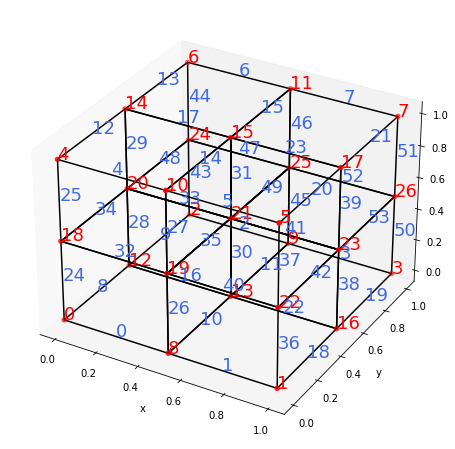

In [29]:
M.draw(nodes=True, vertex_idx=True, knots=False, edge_idx=True)

In [6]:
(13,15) in M.edges

False

In [7]:
kvs = 2*(3*(bspline.make_knots(1,0.0,1.0,2),),)
geos = [
    geometry.unit_cube(),
    geometry.unit_cube().translate((1,0,0))
]

patches = [(kv,geo) for kv, geo in zip(kvs,geos)]
M = PatchMesh3D(patches)

In [9]:
_=M.split_patches({0:1})

(16, 17)
(18, 19)
(16, 18)
(17, 19)


AttributeError: 'NoneType' object has no attribute 'return_segments'

In [13]:
M

In [14]:
face_indices(3,2,z=False)

[[(0,), (0,)],
 [(0,), (1,)],
 [(1,), (0,)],
 [(1,), (1,)],
 [(2,), (0,)],
 [(2,), (1,)]]

In [55]:
import itertools
kvs=(bspline.make_knots(1,0.0,1.0,1),bspline.make_knots(1,0.0,1.0,2),bspline.make_knots(1,0.0,1.0,1))
(axis, sides) = ((0,),(0,))
N = tuple(kv.numdofs for kv in kvs)

In [56]:
geo1=geometry.unit_square()
geo2=geo1.translate((1,0))

In [58]:
assemble._check_geo_match(geo1.boundary([(0,0)]), geo2.boundary([(0,0)]))

(False, (None, None))

In [78]:
def slice_indices(axis, sides, shape, ravel=False, swap=None, flip=None):
    """Return dof indices for a slice of a tensor product basis with size
    `shape`. The slice is taken across index `idx` on axis `ax`.
    The indices are returned either as a `N × dim` array of multiindices or,
    with `ravel=True`, as an array of sequential (raveled) indices.
    """
    shape = tuple(shape)
    dim = len(shape)
    not_axis = tuple(np.setdiff1d(range(dim),axis))
    sides=list(sides)
    
    for i,ax in enumerate(axis):
        if sides[i] < 0:
            sides[i] += shape[ax]     # wrap around
    axdofs = [np.arange(n) for n in shape]

    if flip is not None:
        flip = list(flip)
        #flip = flip[:ax] + (False,) + flip[ax:]     # insert trivial axis
        for ax in axis:
            flip.insert(ax, False)    # insert trivial axis
        for i, flp in enumerate(flip):
            if flp:
                axdofs[i] = np.flip(axdofs[i])
    for ax, idx in zip(axis,sides):
        axdofs[ax]=np.array([idx])
        
    axdofs_ = [axdofs[ax] for ax in not_axis]
    if swap is not None:
        k=0
        for i in range(dim):
            if i in axis:
                axdofs[i] = axdofs[i]
            else:
                axdofs[i]=axdofs_[swap[k]]
                k += 1
    #return axdofs
    
    multi_indices = np.array(list(itertools.product(*axdofs)))
    if swap is not None:
        multi_indices[:,not_axis] = multi_indices[:,not_axis][:,swap]
    if ravel:
        multi_indices = np.ravel_multi_index(multi_indices.T, shape)
    return multi_indices

In [81]:
n=3
m=0
for s in E(n,m,z=False):
    print(slice_indices(*s, N, ravel=True))

[0]
[1]
[4]
[5]
[6]
[7]
[10]
[11]


In [448]:
slice_indices((0,1),(0,-1), N, ravel=True)

array([4, 5])

In [22]:
assemble.boundary_dofs(kvs,((0,2),(0,1)), ravel=True)

array([1, 3, 5])

In [86]:
A[(1,3)]

TypeError: list indices must be integers or slices, not tuple

In [158]:
def edges(corners):
    C=np.array(corners).reshape(2,2,2)
    return np.vstack((C.reshape(-1,2), C.transpose((0,2,1)).reshape(-1,2), C.transpose((1,2,0)).reshape(-1,2)))
def corners(geo, ravel=False):
    """Return an array containing the locations of the 2^d corners of the given
    geometry."""
    vtx = geo.grid_eval(geo.support)
    if ravel:
        return vtx.reshape((-1, geo.dim))
    return vtx

In [142]:
edges(range(8))

array([[0, 1],
       [2, 3],
       [4, 5],
       [6, 7],
       [0, 2],
       [1, 3],
       [4, 6],
       [5, 7],
       [0, 4],
       [1, 5],
       [2, 6],
       [3, 7]])

In [144]:
C=np.array(range(8)).reshape(2,2,2)

In [155]:
C.transpose((1,2,0)).reshape(-1,2)

array([[0, 4],
       [1, 5],
       [2, 6],
       [3, 7]])

In [159]:
geo=geometry.unit_cube()

In [167]:
corners(geo).reshape(-1,3)[0]

array([0., 0., 0.])

In [118]:
[1,2,3].translate((1,2,0))

AttributeError: 'list' object has no attribute 'translate'

In [37]:
s=3
axis = (1,)
naxis = setdiff1d(range(s),axis)
swap = (1,0)
flip = (True, False)

In [40]:
flip = np.array(flip)
flip

array([ True, False])

In [119]:
A=np.array([0,1,2,3,4])

In [160]:
A=np.array([np.array([1,2,3] for i in range(3))])
print(A)

[array(<generator object <genexpr> at 0x7fb96c144890>, dtype=object)]


In [159]:
list(itertools.product([range(2),range(3)]))

[(range(0, 2),), (range(0, 3),)]

In [44]:
A=np.array([1,2,3])

In [49]:
A[np.array((1,2,0))]

array([2, 3, 1])

In [59]:
axis=(2,3)

In [60]:
flip = 3*(True,)

In [61]:
flip = list(flip)

In [62]:
flip.insert(2,False)
flip.insert(3,False)

In [63]:
flip

[True, True, False, False, True]

In [77]:
np.setdiff1d((0,1,2),(0,1))

array([2])

In [94]:
A=[0,1,2]

In [95]:
A[np.array([1])]

TypeError: only integer scalar arrays can be converted to a scalar index

In [106]:
axis = (2,)
swap = (1,0)
A=np.array([0,1,2])

In [107]:
A[np.setdiff1d(range(len(A)),axis)] = A[np.setdiff1d(range(len(A)),axis)][list(swap)]

In [108]:
A

array([1, 0, 2])

In [146]:
def f(x,y): return 1

In [148]:
f(*np.array([0,1]))

1

In [17]:
alpha=1.1
t =np.linspace(0,1,100)
f1= lambda t: alpha*t**(alpha-1)
f2= lambda t: alpha*(alpha-1)*t**(alpha-2)

<ipython-input-17-238eb6852f34>:4: RuntimeWarning: divide by zero encountered in power
  f2= lambda t: alpha*(alpha-1)*t**(alpha-2)


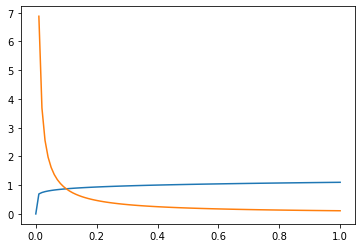

In [18]:
plt.plot(t,f(t))
plt.plot(t,f2(t))